In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We now use the full dataset to create our final model.

## Loading/formatting data
First, we load our data and format/normalize it so that it can be plugged directly into sklearn.

In [4]:
reviews = pd.read_parquet('../data/clean_columns/reviews_clean_dense.parquet')
reviews['AffinityMatrixValue'] = 1
mat_df = pd.pivot_table(data=reviews,index='AuthorId',columns='RecipeId',values='AffinityMatrixValue',fill_value = 0)
affinity_matrix = mat_df.values
userids_ordered = list(mat_df.index)
recipeids_ordered = list(mat_df.columns)
affinity_matrix_mean_zero = [r - np.mean(r) for r in affinity_matrix]

## Fitting final model
We fit the SVD model to the complete affinity matrix.

In [5]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
user_matrix = svd.fit_transform(affinity_matrix_mean_zero)
recipe_matrix = svd.components_

In [17]:
mean_score_on_df = ((np.matmul(user_matrix,recipe_matrix)*affinity_matrix).sum())/(affinity_matrix.sum())

In [18]:
mean_score_on_df

0.021931745566139416

This score is actually higher than the raw score we had on the training set.

## Storing final model

We will store the user and recipe vectors in a dataframe.

The user vectors will go in their own dataframe

In [12]:
uservectors = pd.DataFrame({'AuthorId':userids_ordered,
                            'SVD_component0':user_matrix[::,0],
                            'SVD_component1':user_matrix[::,1]})
uservectors.set_index('AuthorId',inplace=True)

In [21]:
uservectors.to_pickle('UserVectors.pk')

We will store the recipe vectors obtained from SVD in a dataframe that also contains semantic information about the recipes.

In [19]:
recipevectors = pd.DataFrame({'RecipeId':recipeids_ordered,
                            'SVD_component0':recipe_matrix[0]/mean_score_on_df,
                            'SVD_component1':recipe_matrix[1]/mean_score_on_df})
recipevectors.set_index('RecipeId',inplace=True)

In [24]:
recipe_names = pd.read_parquet('../data/clean_columns/RCnames.parquet')

In [30]:
recipe_names['SVDvec'] = [recipevectors.loc[recipevectors.index==recipe_id].values[0]
                          for recipe_id in recipe_names.index]

In [35]:
recipe_names.to_pickle('RecipeVectorsFull.pk')

In [33]:
recipe_names=recipe_names.rename(columns = {'EmbeddedVector':'SemanticVector'})

In [34]:
recipe_names

,Name,Description,SemanticVector,SVDvec
RecipeId,,,,
44,Warm Chicken A La King,I copied this one out of a friend's book so ma...,"[-0.054756664, -0.022292135, -0.044101328, 0.0...","[-0.1431959040401045, -0.20815050512749772]"
49,Chicken Breasts Lombardi,Make and share this Chicken Breasts Lombardi r...,"[-0.08216415, -0.008401718, 0.013638962, 0.048...","[-0.0924041681197167, -0.2040940378876749]"
54,Carrot Cake,This is one of the few recipes my husband ever...,"[-0.10484946, 0.0059982915, 0.004569068, 0.029...","[-0.17736505764494923, -0.19279416904364508]"
56,Buttermilk Pie,This recipe was originally noted by my wife on...,"[-0.011826418, 0.018390462, 0.06946771, 0.0831...","[0.6088236073865996, -0.18224591391038716]"
102,Cheesy Scalloped Potato Side Dish,--Adopted Recipe--\r\nThis is a simple scallop...,"[0.060337774, -0.009301879, -0.07051247, -0.04...","[0.16648108370330122, -0.1342798339332645]"
...,...,...,...,...
518151,A.1. Pot Stickers With Chili Pineapple Dipping...,A.1. Original Sauce Recipe Contest Entry. Thi...,"[-0.12612435, 0.019836454, 0.0010187336, 0.077...","[-0.193720940401693, -0.23454767279647917]"
518229,Charge Me up A1 Steak &amp; Egg Veggie Breakfa...,A.1. Original Sauce Recipe Contest Entry. Thi...,"[-0.14142397, 0.08370191, 0.011463637, 0.04493...","[-0.19349314077959917, -0.23125625124209565]"
522889,Swiss Eggs,Make and share this Swiss Eggs recipe from Foo...,"[-0.058231372, 0.050148107, 0.01968276, 0.0231...","[-0.13180838866567351, 0.5251048551065447]"


In [ ]:
recipe_names = pd.read_parquet('../data/clean_columns/RCnames.parquet')
recipe_names['SVDvec'] = [np.transpose(rmat)[recipe_id_to_index[rec_id]]
                          for rec_id in recipe_names.index]
mean_length = recipe_names['SVDvec'].apply(lambda x:np.linalg.norm(x)).mean()
recipe_names['SVDvec_norm'] = recipe_names.SVDvec/mean_length
recipe_names = recipe_names[['Name','SVDvec_norm']]

## Visualizing the final model

Our final embeddings live in $\mathbb{R}^2$ so we can visualize the result without needing to do any additional dimension reduction.

In [83]:
import matplotlib as mpl
cmap = mpl.colormaps['hsv']


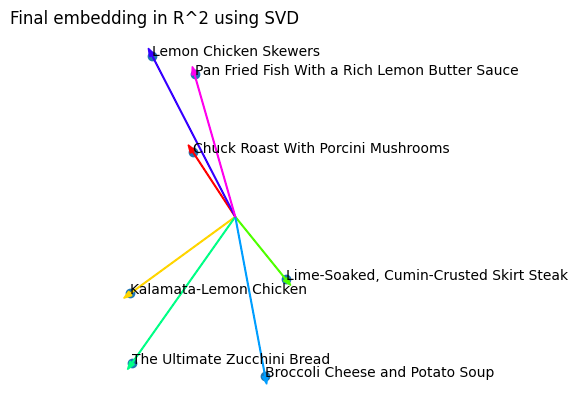

In [86]:
df0 = recipe_names.sample(7,random_state=3)
pts = df0.SVDvec.values
xs = np.transpose(list(pts))[0]
ys = np.transpose(list(pts))[1]
names = list(df0.Name)

fig,ax = plt.subplots()
ax.scatter(xs,ys)
for i, txt in enumerate(names):
    ax.annotate(txt, (xs[i], ys[i]))
    plt.arrow(x=0,y=0,dx = xs[i],dy=ys[i],head_width = 0.008,color=cmap(i/len(names)))


ax.axis('off')
plt.gca().set_aspect('equal')
plt.title('Final embedding in R^2 using SVD',loc='right')
plt.show()

In [ ]:

plt.arrow(x=0,y=0,dx = xs[i],dy=ys[i],head_width = 0.04)
plt.arrow(x=0,y=0,dx = -np.sqrt(3/4),dy=-0.5,head_width = 0.04)